In [1]:
import sys

from pathlib import Path

from dotenv import find_dotenv, load_dotenv
# find .env automagically by walking up directories until it's found, then
# load up the .env entries as environment variables
load_dotenv(find_dotenv())

PROJ_ROOT = Path('/home/bruno-pacheco/brain-age')

from tqdm.notebook import tqdm

import numpy as np

import matplotlib.pyplot as plt

In [19]:
import wandb

import torch
from torch import nn

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def load_from_wandb(net: nn.Module, run_id: str,
                    project='ADNI-brain-age'):
    best_model_file = wandb.restore(
        'model_last.pth',
        run_path=f"gama/{project}/{run_id}",
    )
    net.load_state_dict(torch.load(best_model_file.name))

    return net

class BraTSnnUNet(nn.Module):
    def __init__(self, network, freeze=False):
        """`network` must be a nnU-Net `Generic_UNet`.
        """
        super().__init__()

        self.brats_encoder = network.conv_blocks_context

        self.pooling = nn.AvgPool2d(5)

        self.fc = nn.Linear(480,1)

        if freeze:
            self.freeze()

    def forward(self, x):
        for d in range(len(self.brats_encoder)):
            x = self.brats_encoder[d](x)

        x = self.pooling(x)

        y = self.fc(x.squeeze()).squeeze()

        return y

    def freeze(self):
        for param in self.brats_encoder.parameters():
            param.requires_grad = False

    def unfreeze(self):
        for param in self.model.brats_encoder.parameters():
            param.requires_grad = True

In [20]:
net = torch.load('/home/bruno-pacheco/brain-age/models/brats_model.pt')
net = load_from_wandb(net, '21ox5guw').to(device)
net.eval()
net

ValueError: File model_last.pth not found in gama/ADNI-brain-age/21ox5guw.

In [ ]:
import h5py

from torch.utils.data import Dataset
from torchvision import transforms


class ADNIDatasetForBraTSModel(Dataset):
    def __init__(
        self,
        hdf5_fpath,
        transform=transforms.ToTensor(),
        dataset='train',
    ) -> None:
        super().__init__()

        hdf5_fpath = Path(hdf5_fpath)
        assert hdf5_fpath.exists()

        self._fpath = hdf5_fpath
        self.dataset = dataset

        self.transform = transform

    def __len__(self):
        with h5py.File(self._fpath, 'r') as h:
            l = h[self.dataset]['y'].shape[0]

        return l

    def __getitem__(self, index: int):
        with h5py.File(self._fpath, 'r') as h:
            img = h[self.dataset]['X'][index]
            label = h[self.dataset]['y'][index]

        # transform
        if self.transform:
            img = self.transform(img)

        return img, label

val_data = ADNIDatasetForBraTSModel('/home/bruno-pacheco/brain-age/data/interim/ADNI_slices.hdf5', dataset='test')
len(val_data)

In [21]:
from torch.utils.data import DataLoader

val_dataloader = DataLoader(val_data, batch_size=80, shuffle=False)

Y_pred = list()
Y = list()
for X, y in tqdm(val_dataloader):
    X, y = X.to(device), y.to(device)

    Y_pred.append(net(X).cpu().detach().numpy())
    Y.append(y.cpu().detach().numpy())

RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

In [15]:
Y = np.array(Y)
Y_pred = np.array(Y_pred)

# some subjects are 0-aged
Y_pred = Y_pred[(Y != 0).any(axis=-1)]
Y = Y[(Y != 0).any(axis=-1)]

Per-image MAE   = 4.1905
Per-subject MAE = 3.6190 (mean agg)
Per-subject MAE = 3.6125 (median agg)


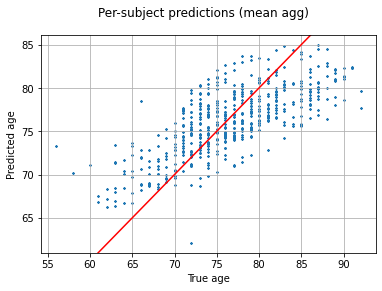

In [16]:
image_MAE = np.abs(Y_pred - Y).mean()
subject_Y_pred = Y_pred.mean(axis=-1)
subject_MAE = np.abs(subject_Y_pred - Y[:,0]).mean()

print(f"Per-image MAE   = {image_MAE:.4f}")
print(f"Per-subject MAE = {subject_MAE:.4f} (mean agg)")
print(f"Per-subject MAE = {np.abs(np.median(Y_pred, axis=-1) - Y[:,0]).mean():.4f} (median agg)")

plt.suptitle('Per-subject predictions (mean agg)')
plt.scatter(Y[:,0], subject_Y_pred, s=3, marker='x')
xlim = plt.xlim()
ylim = plt.ylim()
plt.plot([0.,100.],[0.,100.], 'r')
plt.xlim(xlim)
plt.ylim(ylim)
plt.xlabel('True age')
plt.ylabel('Predicted age')
plt.grid()
plt.show()

Mean = 76.34
Std  = 6.47


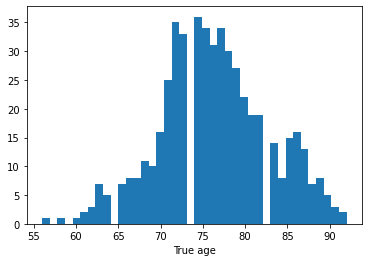

In [17]:
import matplotlib.pyplot as plt

print(f'Mean = {Y[:,0].mean():.2f}')
print(f'Std  = {Y[:,0].std():.2f}')

plt.hist(Y[:,0], bins=40)
plt.xlabel('True age')
plt.show()

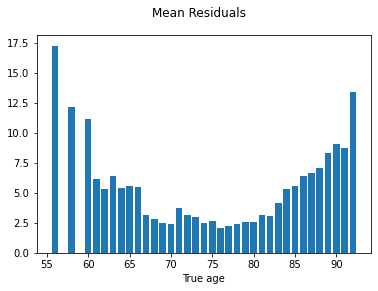

In [18]:
Y_ = Y[:,0]
i_ = np.argsort(Y_)
Y_grouped = np.split(Y_[i_], np.unique(Y_[i_], return_index=True)[1][1:])
grouped_mean_residuals = np.array([np.mean(rs) for rs in np.split(np.abs(subject_Y_pred - Y[:,0])[i_], np.unique(Y_[i_], return_index=True)[1][1:])])

plt.suptitle('Mean Residuals')
plt.bar(np.unique(Y_[i_]), grouped_mean_residuals)
plt.xlabel('True age')
plt.show()